In this colab, we use a dataset of colored shapes.

<img src="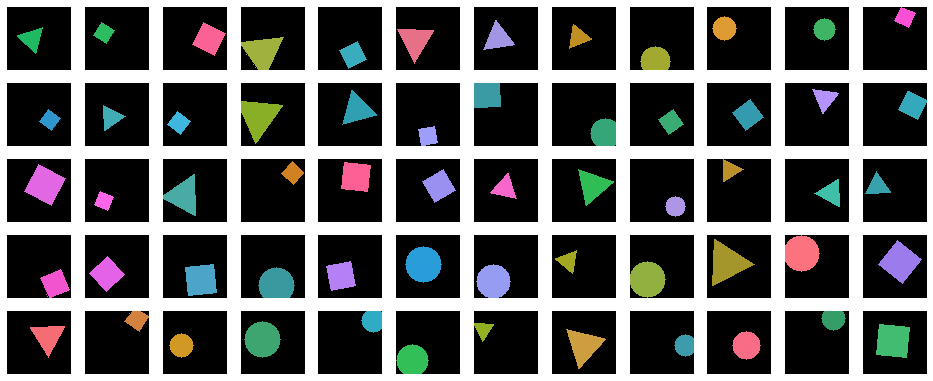
">

Each image has resolution $64 \times 64$. Across the dataset, there are three underlying varying factors:

+ Shape 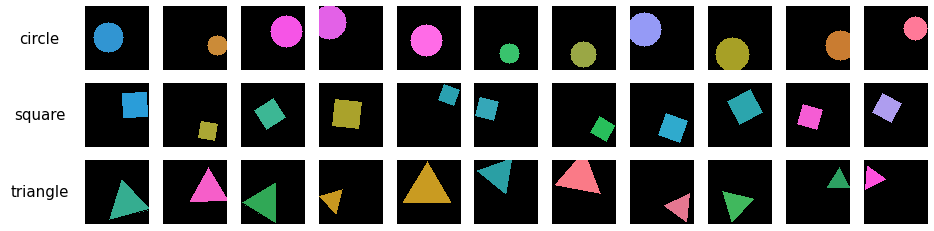
+ Color 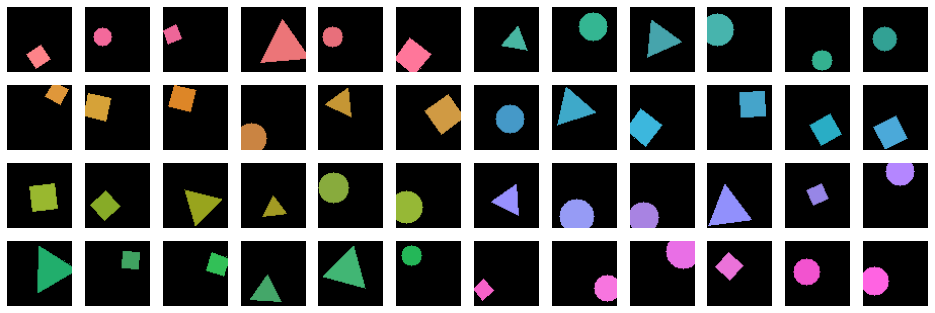
+ Location <img src="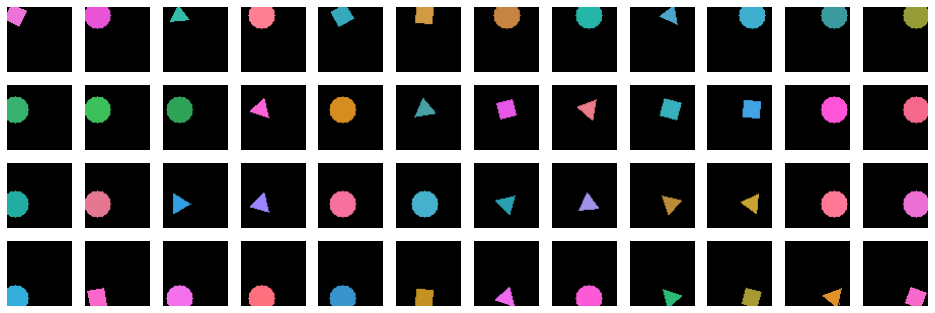
">

Without using any labelled information about these factors, we train autoencoders and contrastive encoders on this dataset, and evaluate the resulting latent spaces via nearest neighbor classification to test the encoders learn to capture these factors.

**NOTE:** Most of the code are provided in this colab. You are not required to fully read through the implementation of them, but should conceptually understand what the functions/classes with **docstrings** are doing.

In [1]:
from typing import *
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import contextlib

import torch
from torch import nn, optim
from torch.nn import functional as F

device = torch.device('cuda:0')
assert torch.cuda.is_available()

import torchvision
from IPython import display
from PIL import Image

from tqdm.auto import tqdm
!pip install gdown
!gdown 1VWqzW3GiFEnQhYhdoxDhHWUcdIuWLf3m

!pip install scikit-dimension
!pip install ripser persim

from google.colab import output
output.clear()

# Dataset

In [2]:
# Load data
data = np.load('/content/shapes_dataset_6s898.npy', allow_pickle=True).item()
train_indices, val_indices = torch.arange(data['imgs'].shape[0]).split([64000 - 24000, 24000])


class Dataset:
    r'''
    Our dataset object for loading shapes dataset.
    '''

    def __init__(self, split: str, transform=None, num_samples: int = 1):
        r'''
        split (str): Whether to load training of validation images. Should be 'train' or 'val'.
        transform: Transformations on raw data, e.g., augmentations and/or normalization.
                   `to_tensor` and normalization is called automatically.
                   No need to explicitly pass in `ToTensor()` or `Normalize()`.
        num_samples (int):Number of transformed versions to return for each sample.
                           For autoencoder, this is 1. For contrastive, this is 2.
        '''
        self.split = split
        if split == 'train':
            self.indices = train_indices
        else:
            assert split == 'val'
            self.indices = val_indices
        self.num_samples = num_samples
        if transform is None:
            transform = lambda x: x
        self.transform = transform

    def get_augs(self, idx, num_samples):
        img = torchvision.transforms.functional.to_tensor(data['imgs'][self.indices[idx]])
        return tuple(self.transform(img).clamp(0, 1) for _ in range(num_samples))

    def __getitem__(self, idx):
        r'''
        Fetech the data at index `idx`
        '''
        return tuple(tensor.sub(0.5).div(0.5) for tensor in self.get_augs(idx, num_samples=self.num_samples))

    def visualize(self, idx, num_samples=None):
        r'''
        Visualize the image at index `idx` for `num_samples` times (default to `self.num_samples`).

        These samples will be different if `self.transform` is random.
        '''
        if num_samples is None:
            num_samples = self.num_samples
        f, axs = plt.subplots(1, num_samples, figsize=(1.2 * num_samples, 1.4))
        if num_samples == 1:
            axs = [axs]
        else:
            axs = axs.reshape(-1)
        for ax, tensor in zip(axs, self.get_augs(idx, num_samples)):
            ax.axis('off')
            ax.imshow(tensor.permute(1, 2, 0))
        title = f'{self.split} dataset[{idx}]'
        if num_samples > 1:
            title += f'  ({num_samples} samples)'
        f.suptitle(title, fontsize=17, y=0.98)
        f.tight_layout(rect=[0, 0.03, 1, 0.9])
        return f

    def __len__(self):
        return self.indices.shape[0]

# Network architectures

Our encoder and decoder networks are standard CNNs! You should have no issues understand the following code.

In [4]:
# encoder architecture
class Encoder(nn.Module):
    def __init__(self, latent_dim, normalize: bool = False):
        r'''
        latent_dim (int): Dimension of latent space
        normalize (bool): Whether to restrict the output latent onto the unit hypersphere
        '''
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1) # 64x64 --> 32x32
        self.conv2 = nn.Conv2d(32, 32*2, 4, stride=2, padding=1) # 32x32 --> 16x16
        self.conv3 = nn.Conv2d(32*2, 32*4, 4, stride=2, padding=1) # 16x16 --> 8x8
        self.conv4 = nn.Conv2d(32*4, 32*8, 4, stride=2, padding=1) # 8x8 --> 4x4
        self.conv5 = nn.Conv2d(32*8, 32*16, 4, stride=2, padding=1) # 4x4 --> 2x2
        self.conv6 = nn.Conv2d(32*16, latent_dim, 4, stride=2, padding=1) # 2x2 --> 1x1
        self.fc = nn.Linear(latent_dim, latent_dim)

        self.nonlinearity = nn.ReLU()
        self.normalize = normalize

    def forward(self, x):
        x = self.nonlinearity(self.conv1(x))
        x = self.nonlinearity(self.conv2(x))
        x = self.nonlinearity(self.conv3(x))
        x = self.nonlinearity(self.conv4(x))
        x = self.nonlinearity(self.conv5(x))
        x = self.nonlinearity(self.conv6(x).flatten(1))
        x = self.fc(x)
        if self.normalize:
            x = F.normalize(x)
        return x

    def extra_repr(self):
        return f'normalize={self.normalize}'


# decoder architecture
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        r'''
        latent_dim (int): Dimension of latent space
        '''
        super(Decoder, self).__init__()

        self.conv1 = nn.ConvTranspose2d(latent_dim, 32*16, 4, stride=2, padding=1) # 1x1 --> 2x2
        self.conv2 = nn.ConvTranspose2d(32*16, 32*8, 4, stride=2, padding=1) # 2x2 --> 4x4
        self.conv3 = nn.ConvTranspose2d(32*8, 32*4, 4, stride=2, padding=1) # 4x4 --> 8x8
        self.conv4 = nn.ConvTranspose2d(32*4, 32*2, 4, stride=2, padding=1) # 8x8 --> 16x16
        self.conv5 = nn.ConvTranspose2d(32*2, 32, 4, stride=2, padding=1) # 16x16 --> 32x32
        self.conv6 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1) # 32x32 --> 64x64
        self.nonlinearity = nn.ReLU()

    def forward(self, z):
        z = z[..., None, None]  # make it convolution-friendly

        x = self.nonlinearity(self.conv1(z))
        x = self.nonlinearity(self.conv2(x))
        x = self.nonlinearity(self.conv3(x))
        x = self.nonlinearity(self.conv4(x))
        x = self.nonlinearity(self.conv5(x))
        return self.conv6(x)

# Nearest Neighbor Visualization

We provide a function `nn_visualize` that visualizes an encoder's embedding by plotting the nearest neighbors.  In particular, for an  input image, we plot the images that are closest to them in the feature space. By looking at them, we can understand what images the encoder considers similar (i.e., having low feature space distance).

There is no need to fully understand the code, but please look at the random encoder visualization below and make sure you understand what each image in the plot means.

In [5]:
@torch.no_grad()
def get_features(dataset: Dataset, encoder: Encoder, firstk: Optional[int] = None):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, pin_memory=True)
    n = 0
    features = []
    for batches in dataloader:
        batch = batches[0]
        features.append(encoder(batch.to(device)))
        n += batch.shape[0]
        if firstk is not None and n >= firstk:
            break
    features = torch.cat(features)
    if firstk is not None:
        features = features[:firstk]
    return features

@torch.no_grad()
def nn_visualize(dataset: Dataset, encoder: Encoder, num_nn: int = 10, desc: str = ''):
    r'''
    For a given `dataset` object, visualize `encoder` by nearest neighbors.

    In particular, the function takes `8` samples from `dataset`, computes
    their `num_nn` nearest neighbor samples (w.r.t. l2 embedding distance induced by
    `encoder`), and produces a plot.

    `desc` is a string description that is used to set the title of the plot.
    '''
    all_features = get_features(dataset, encoder, firstk=24000)
    source_feat = all_features[:8]
    dists = (source_feat[:, None] - all_features).pow(2).sum(-1)
    knns = torch.topk(dists, num_nn, dim=-1, largest=False).indices.cpu()

    nrow = knns.shape[0]
    ncol = num_nn + 2
    f, axes = plt.subplots(nrow, ncol, figsize=(ncol * 1, nrow * 1.1 + 1))
    for ax in axes.reshape(-1):
        ax.axis('off')

    axes[0, 0].set_title('Input Image', fontsize=15)

    for ax, imidx in zip(axes[:, 0], dataset.indices):
        ax.imshow(data['imgs'][imidx])

    for j in range(2, ncol):
        axes[0, j].set_title(f'NN {1 +j-2}', fontsize=15)

    for i in range(nrow):
        for j in range(2, ncol):
            axes[i, j].imshow(data['imgs'][dataset.indices[knns[i, j - 2]]])

    f.suptitle(f'{desc} Nesrest Neighbors (NNs) on {dataset.split.capitalize()} Set \n(near -> far, NN 1 is closest)', fontsize=20, y=0.98)
    f.tight_layout(rect=[0, 0.03, 1, 0.9])
    f.subplots_adjust(wspace=0.05, hspace=0.1)
    f.show()

# Autoencoder

In [7]:
def train_autoencoder(latent_dim: int):
    r'''
    Train encoder and decoder networks with `latent_dim` latent dimensions according
    to the autoencoder objective (i.e., MSE reconstruction).

    Returns the trained encoder and decoder.
    '''
    enc = Encoder(latent_dim).to(device)
    dec = Decoder(latent_dim).to(device)

    optim = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=2e-4)

    dataset = Dataset('train')
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, pin_memory=True)
    num_epochs = 30

    for epoch in tqdm(range(num_epochs), desc=f'{num_epochs} epochs total'):
        for batch, in dataloader:
            batch = batch.to(device)
            # batch: a batched image tensor of shape [B x 3 x 64 x 64]

            # FIXME
            loss = nn.MSELoss()(dec(enc(batch)), batch)

            optim.zero_grad()
            loss.backward()
            optim.step()
        print(f'[Autoencoder] epoch {epoch: 4d}   loss = {loss.item():.4g}')

    return enc, dec

In [8]:
@torch.no_grad()
def get_features(dataset: Dataset, encoder: Encoder, firstk: Optional[int] = None):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, pin_memory=True)
    n = 0
    features = []
    for batches in dataloader:
        # Extract the first element (img1, img2) and use the first image only
        img1, _ = batches[0]
        features.append(encoder(img1.to(device)))
        n += img1.shape[0]
        if firstk is not None and n >= firstk:
            break
    features = torch.cat(features)
    if firstk is not None:
        features = features[:firstk]
    return features

# Intrinsic dimension estimation methods

In [9]:
from sklearn.decomposition import PCA

def PCA_estim(act, threshold):
    """
    act: torch.tensor, shape (N, D)
    threshold: float, the minimum variance to explain
    """
    pca = PCA()
    pca.fit(act)

    explained_variance_ratios = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratios)
    num_components = np.searchsorted(cumulative_variance, threshold) + 1

    return num_components

In [10]:
from sklearn.neighbors import NearestNeighbors

def knn_estim(act, k=5):
    """
    Estimate the intrinsic dimension of data using k-nearest neighbors.

    Parameters:
    - data: numpy array of shape (n_samples, n_features)
    - k: the number of nearest neighbors to use for estimation
    """
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(act)
    distances, _ = nbrs.kneighbors(act)
    ratios = distances[:, 2:] / distances[:, 1:-1]
    mean_log_ratios = np.mean(np.log(ratios), axis=1)
    intrinsic_dimension = (k - 1) / np.mean(mean_log_ratios)
    return intrinsic_dimension

In [11]:
from scipy.stats import linregress

def correlation_dimension(data, eps_range=None, n_points=20):
    """
    Estimates intrinsic dimension using correlation dimension method.
    Based on counting pairs of points within increasing distances.
    """
    if eps_range is None:
        # Compute reasonable epsilon range based on data spread
        dists = np.linalg.norm(data[:, None] - data, axis=2)
        eps_range = np.logspace(
            np.log10(np.percentile(dists, 1)),
            np.log10(np.percentile(dists, 90)),
            n_points
        )

    n_samples = len(data)
    correlations = []

    for eps in eps_range:
        # Count pairs of points closer than epsilon
        dists = np.linalg.norm(data[:, None] - data, axis=2)
        pairs = np.sum(dists < eps) - n_samples  # Subtract self-pairs
        correlation = pairs / (n_samples * (n_samples - 1))
        correlations.append(correlation)

    # Estimate dimension from log-log slope
    log_eps = np.log(eps_range)
    log_corr = np.log(correlations)
    slope, _, _, _, _ = linregress(log_eps, log_corr)
    return slope

In [12]:
import skdim

def ID_estim(act, danco=False, corr=False, twoNN=True, local=[]):
    """
    act: torch.tensor, shape (N, D)
    local: whether to run lpca estimation
    """
    if danco:
        result = skdim.id.DANCo().fit_transform(act)
        print("DANCo estimate:", result)

    if corr:
        result = skdim.id.CorrInt().fit_transform(act)
        print("CorrDim estimate:", result)

    if twoNN:
        result = skdim.id.TwoNN().fit_transform(act)
        print("TwoNN estimate:", result)

    L = []
    for k in local:
        #estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
        result = skdim.id.lPCA().fit_pw(act, n_neighbors = k, n_jobs = 1)
        meow = np.mean(result.dimension_pw_)
        L.append((k, meow))
        print(f"lPCA estimate with {k} neighbors:", meow)

    return L

# Contrastive learning

In [13]:
def change_shape_color(image, color_tensor):
    """
    Change only the shape with the given color tensor.
    """
    image = image.clone()
    mask = (image.sum(dim=0) > 0).float()

    for i in range(3):
        image[i] = image[i] * (1 - mask) + color_tensor[i] * mask

    return image


def shift_shape_location(image, shift_x, shift_y):
    """
    Shift non-dark pixels in the image by (shift_x, shift_y).
    """
    image = image.clone()
    mask = (image.sum(dim=0) > 0).float()
    shifted_image = torch.zeros_like(image)
    h, w = image.shape[1], image.shape[2]

    for c in range(3):
        y_start = max(-shift_y, 0)
        y_end = min(h - shift_y, h)
        x_start = max(-shift_x, 0)
        x_end = min(w - shift_x, w)
        shifted_image[c, y_start + shift_y:y_end + shift_y, x_start + shift_x:x_end + shift_x] = \
            image[c, y_start:y_end, x_start:x_end] * \
            mask[y_start:y_end, x_start:x_end]

    return shifted_image


def get_location_transformation(color_tensor, shift_x, shift_y):
    return transforms.Compose([
        transforms.Lambda(lambda img: change_shape_color(img, color_tensor)),
        transforms.Lambda(lambda img: shift_shape_location(img, shift_x, shift_y))
    ])


def get_shape_transformation(color_tensor, shift_x, shift_y, change_shape):
    if change_shape:
        interpolation = torchvision.transforms.InterpolationMode.NEAREST
        return transforms.Compose([
            torchvision.transforms.RandomApply(
                [
                    torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=(-10, 10, -10, 10), interpolation=interpolation),
                    torchvision.transforms.RandomPerspective(distortion_scale=0.6,  p=1, interpolation=interpolation),
                ],
                p=0.7,
            ),
            transforms.Lambda(lambda img: change_shape_color(img, color_tensor)),  # Modify color of non-dark areas
        ])
    else:
        return transforms.Compose([
            torchvision.transforms.RandomRotation(degrees=(0, 360)),
            transforms.Lambda(lambda img: change_shape_color(img, color_tensor)),  # Modify color of non-dark areas
            transforms.Lambda(lambda img: shift_shape_location(img, shift_x, shift_y))  # Shift non-dark pixels
        ])


def get_color_transformation(change_color):
    if change_color:
        return transforms.Compose([
            torchvision.transforms.RandomGrayscale(p=0.2),
            torchvision.transforms.ColorJitter(hue=.5, brightness=0.3, contrast=0.3, saturation=0.9),
        ])
    else:
        interpolation = torchvision.transforms.InterpolationMode.NEAREST
        return transforms.Compose([
            torchvision.transforms.RandomApply(
                [
                    torchvision.transforms.RandomAffine(degrees=0, translate=(0.3, 0.3), shear=(-80, 80, -80, 80), interpolation=interpolation),
                    torchvision.transforms.RandomPerspective(distortion_scale=0.6,  p=1, interpolation=interpolation),
                ],
                p=0.7,
            )
        ])

In [14]:
def get_source_imgs(target_property):
    positive_imgs, negative_imgs = [], []
    if target_property == 'location':
        positive_imgs = [[data['imgs'][13], data['imgs'][10]], [data['imgs'][1], data['imgs'][6]], [data['imgs'][88], data['imgs'][89]]]
        negative_imgs = [[data['imgs'][1], data['imgs'][10]], [data['imgs'][3], data['imgs'][20]], [data['imgs'][9], data['imgs'][15]]]
        # positive_imgs = [[data['imgs'][13], data['imgs'][51]], [data['imgs'][1], data['imgs'][6]], [data['imgs'][88], data['imgs'][89]]]
        # negative_imgs = [[data['imgs'][1], data['imgs'][10]], [data['imgs'][3], data['imgs'][20]], [data['imgs'][9], data['imgs'][15]]]
    elif target_property == 'shape':
        positive_imgs = [[data['imgs'][1], data['imgs'][10]], [data['imgs'][3], data['imgs'][20]], [data['imgs'][9], data['imgs'][15]]]
        negative_imgs = [[data['imgs'][13], data['imgs'][51]], [data['imgs'][1], data['imgs'][6]], [data['imgs'][88], data['imgs'][89]]]
    elif target_property == 'color':
        positive_imgs = [[data['imgs'][12], data['imgs'][13]], [data['imgs'][215], data['imgs'][216]], [data['imgs'][15], data['imgs'][18]]]
        negative_imgs = [[data['imgs'][6]], [data['imgs'][7]], [data['imgs'][10]]]
    return positive_imgs, negative_imgs

In [15]:
import random
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms


class ContrastiveDataset(Dataset):
    def __init__(self, target_property, positive_ratio=0.5):
        """
        Args:
            input_image: A single image for generating positive pairs.
            negative_images: A list of three images for generating negative pairs.
            transform: Transformations to apply to the images.
            positive_ratio: Proportion of positive pairs in the dataset.
        """
        self.target_property = target_property
        positive_imgs, negative_imgs = get_source_imgs(self.target_property)
        self.positive_imgs_set = positive_imgs
        self.negative_imgs_set = negative_imgs
        self.positive_ratio = positive_ratio


    def __len__(self):
        return 10000


    def __getitem__(self, idx):
        """
        Generate a contrastive pair (positive or negative).
        """
        if random.random() < self.positive_ratio:
            pos_imgs = random.choice(self.positive_imgs_set)
            img1 = torchvision.transforms.functional.to_tensor(pos_imgs[0])
            img2 = torchvision.transforms.functional.to_tensor(pos_imgs[1])
            label = 1
            if self.target_property == 'location':
                shift_x, shift_y = random.randint(-30, 30), random.randint(-30, 30)
                transform_1 = get_location_transformation(torch.tensor([random.random(), random.random(), random.random()]), shift_x, shift_y)
                transform_2 = get_location_transformation(torch.tensor([random.random(), random.random(), random.random()]), shift_x, shift_y)
                img1, img2 = transform_1(img1), transform_2(img2)
            elif self.target_property == 'shape':
                transform_1 = get_shape_transformation(torch.tensor([random.random(), random.random(), random.random()]), random.randint(-30, 30), random.randint(-30, 30), change_shape=False)
                transform_2 = get_shape_transformation(torch.tensor([random.random(), random.random(), random.random()]), random.randint(-30, 30), random.randint(-30, 30), change_shape=False)
                img1, img2 = transform_1(img1), transform_2(img2)
            elif self.target_property == 'color':
                transform = get_color_transformation(change_color=False)
                img1, img2 = transform(img1), transform(img2)
        else:
            neg_imgs = random.choice(self.negative_imgs_set)
            img1 = torchvision.transforms.functional.to_tensor(neg_imgs[0])
            img2 = torchvision.transforms.functional.to_tensor(neg_imgs[0]) if self.target_property == 'color' else torchvision.transforms.functional.to_tensor(neg_imgs[1])
            label = 0
            if self.target_property == 'location':
                color_tensor = torch.tensor([random.random(), random.random(), random.random()])
                transform_1 = get_location_transformation(color_tensor, random.randint(-30, 30), random.randint(-30, 30))
                transform_2 = get_location_transformation(color_tensor, random.randint(-30, 30), random.randint(-30, 30))
                img1, img2 = transform_1(img1), transform_2(img2)
            elif self.target_property == 'shape':
                color_tensor = torch.tensor([random.random(), random.random(), random.random()])
                shift_x, shift_y = random.randint(-30, 30), random.randint(-30, 30)
                transform = get_shape_transformation(color_tensor, shift_x, shift_y, change_shape=True)
                img1, img2 = transform(img1), transform(img2)
            elif self.target_property == 'color':
                transform = get_color_transformation(change_color=True)
                img1, img2 = transform(img1), transform(img2)

        return (img1, img2), label


    def visualize_random_pairs(self, positive, num_pairs=10):
        """
        Visualize random pairs.
        """
        cur_pairs = 0
        while cur_pairs < num_pairs:
            idx = random.randint(0, len(self) - 1)
            (img1, img2), label = self[idx]
            match = label == 1 if positive else label == 0
            if match:
                fig, axes = plt.subplots(1, 2, figsize=(8, 3))
                axes[0].imshow(img1.permute(1, 2, 0).numpy())
                axes[0].set_title("Image 1")
                axes[0].axis('off')
                axes[1].imshow(img2.permute(1, 2, 0).numpy())
                axes[1].set_title(f"Image 2")
                axes[1].axis('off')
                if positive:
                    plt.suptitle(f"Positive Pair {cur_pairs + 1}", fontsize=16)
                else:
                    plt.suptitle(f"Negative Pair {cur_pairs + 1}", fontsize=16)
                plt.tight_layout()
                plt.show()
                cur_pairs += 1

In [16]:
def contrastive_loss(embedding1, embedding2, labels, margin=1.0):
    distances = torch.nn.functional.pairwise_distance(embedding1, embedding2)
    positive_loss = labels * torch.pow(distances, 2)
    negative_loss = (1 - labels) * torch.pow(torch.clamp(margin - distances, min=0), 2)
    loss = torch.mean(positive_loss + negative_loss)
    return loss

In [25]:
def train_contrastive(contrastive_dataset, target_property: str, latent_dim: int, *, tau: float = 0.07, margin=1.0):
    """
    Train the encoder using contrastive learning with the contrastive loss function.
    """
    enc = Encoder(latent_dim, normalize=True).to(device)
    optimizer = torch.optim.Adam(enc.parameters(), lr=2e-4)
    dataloader = DataLoader(contrastive_dataset, batch_size=256, shuffle=True, pin_memory=True)
    num_epochs = 30 if target_property == 'location' else 15

    for epoch in range(num_epochs):
        enc.train()
        epoch_loss = 0

        for (img1, img2), labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} / {num_epochs}"):
            img1, img2, labels = img1.to(device), img2.to(device), labels.float().to(device)
            embedding1 = enc(img1)  # Shape: [B, latent_dim]
            embedding2 = enc(img2)  # Shape: [B, latent_dim]
            loss = contrastive_loss(embedding1, embedding2, labels, margin=margin)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"[Contrastive] Epoch {epoch + 1} / {num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

    return enc

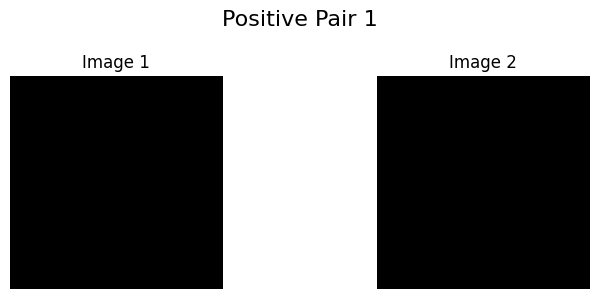

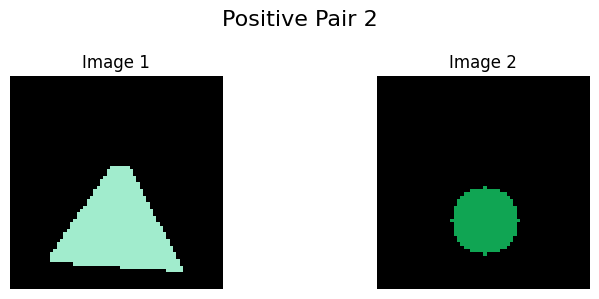

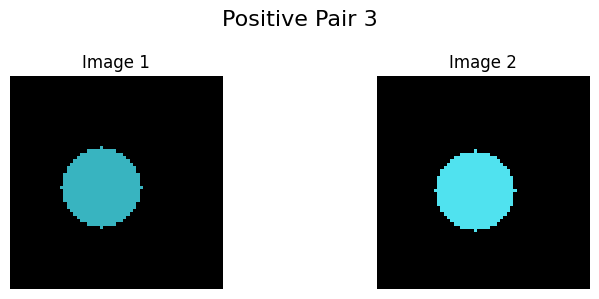

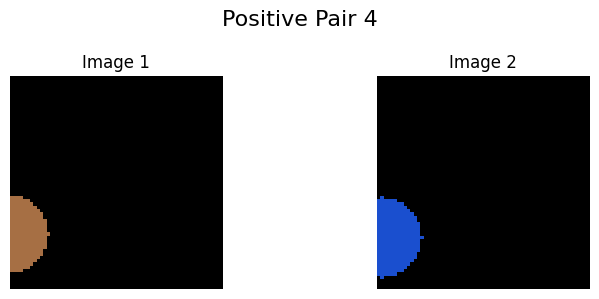

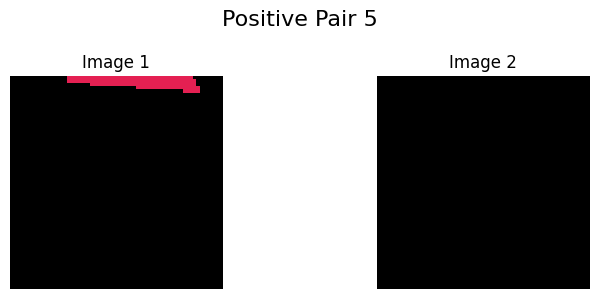

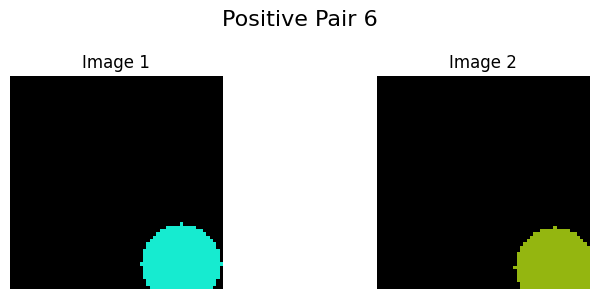

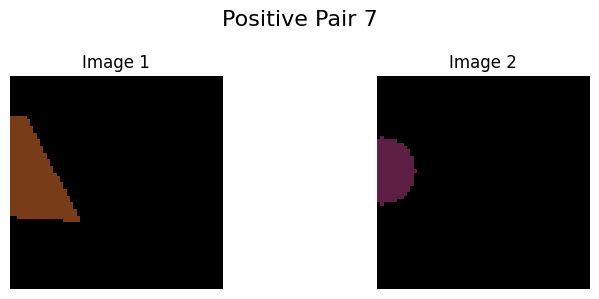

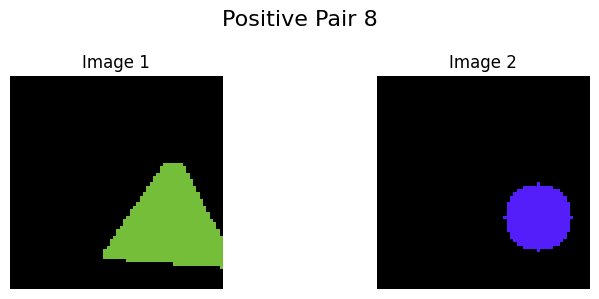

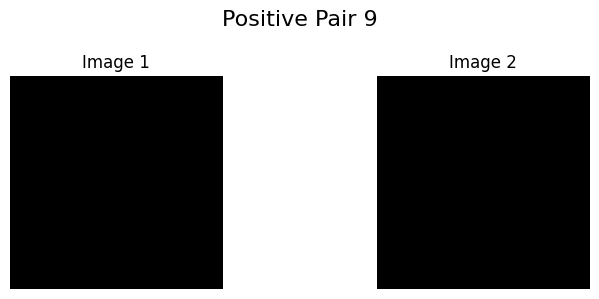

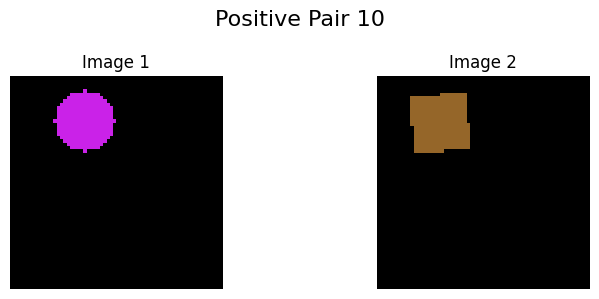

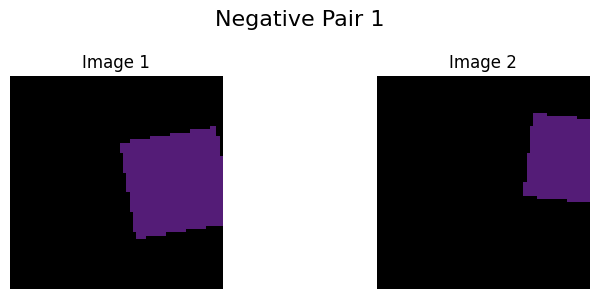

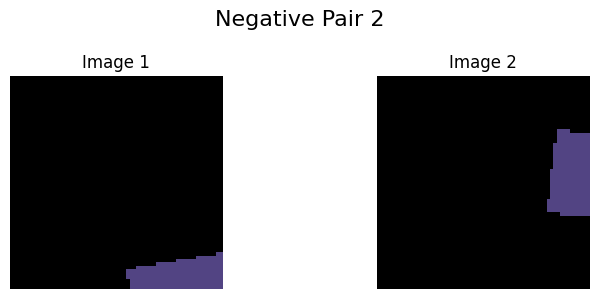

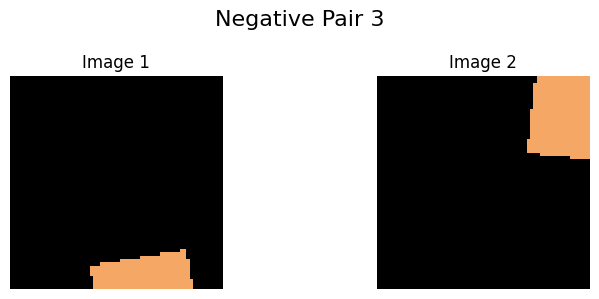

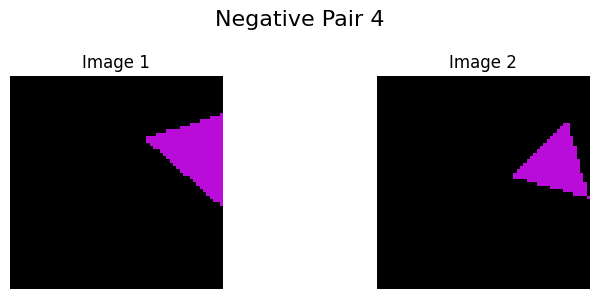

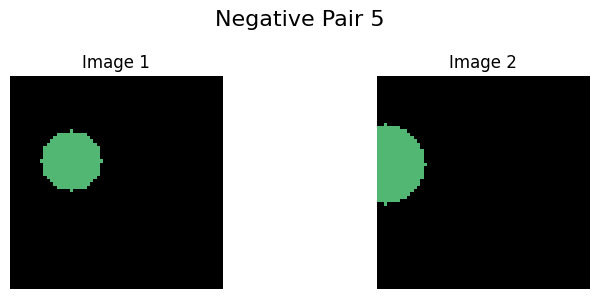

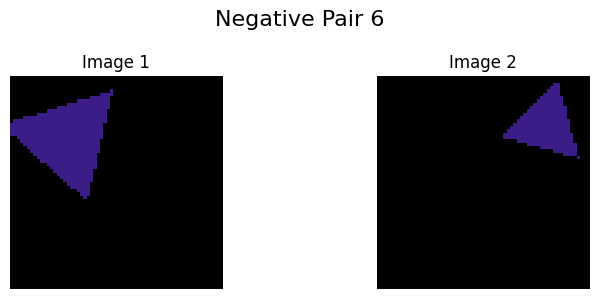

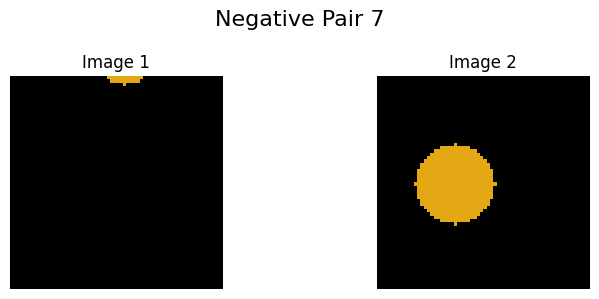

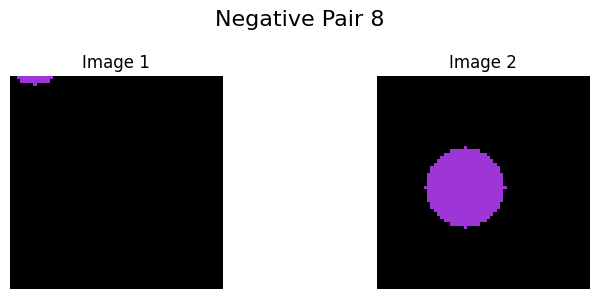

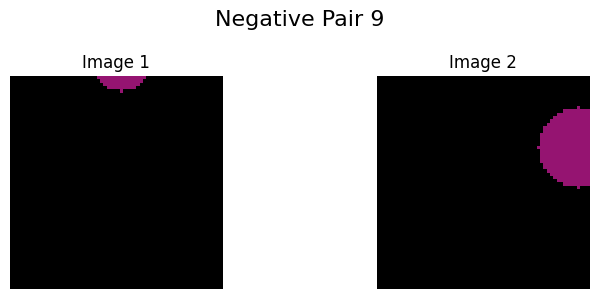

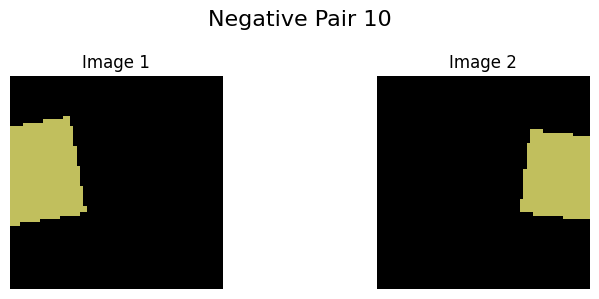

In [18]:
location_dataset = ContrastiveDataset(target_property='location')
location_data_loader = DataLoader(location_dataset, batch_size=32, shuffle=True)

location_dataset.visualize_random_pairs(positive=True)
location_dataset.visualize_random_pairs(positive=False)

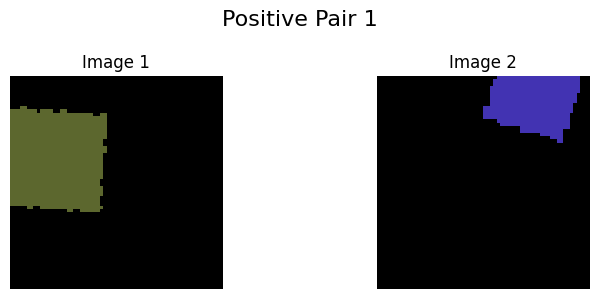

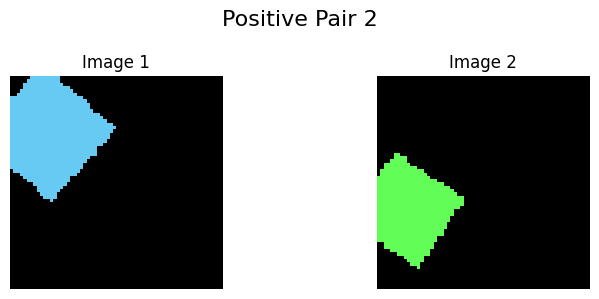

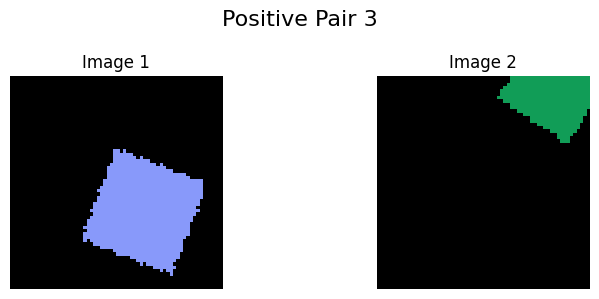

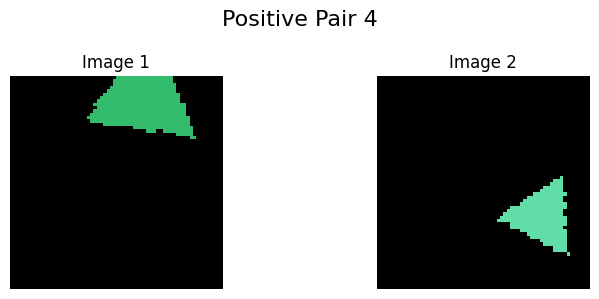

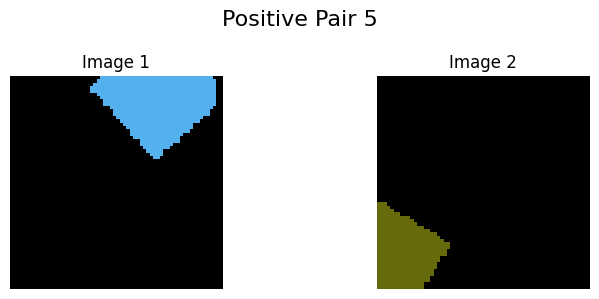

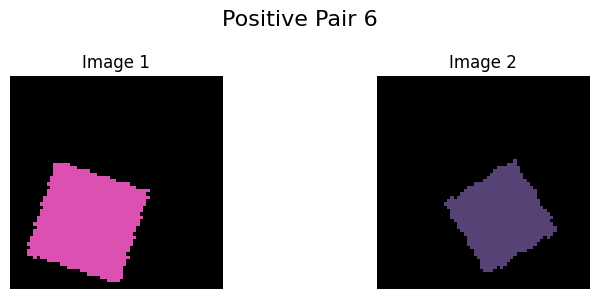

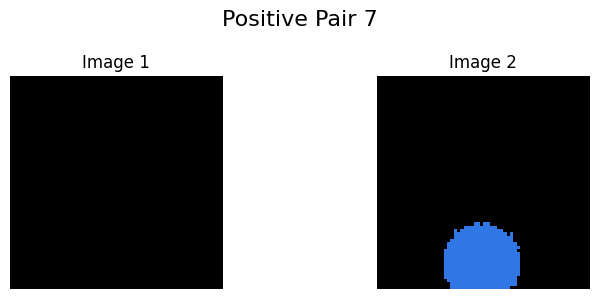

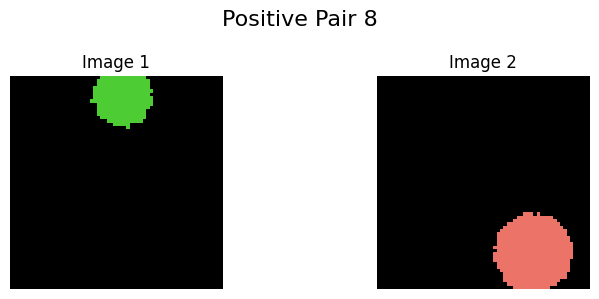

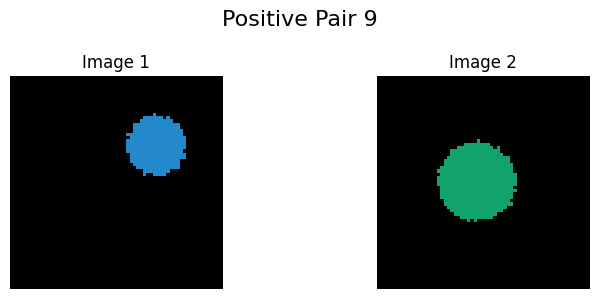

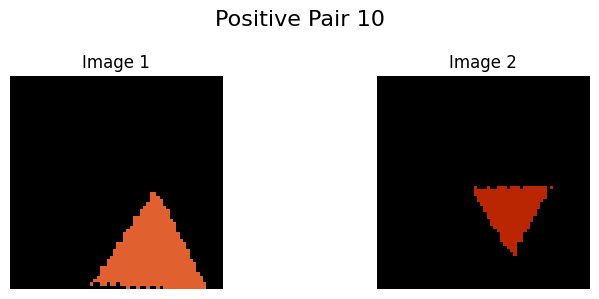

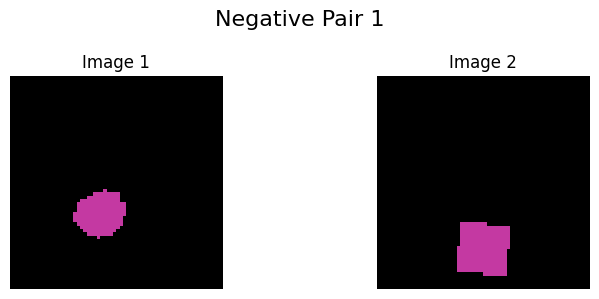

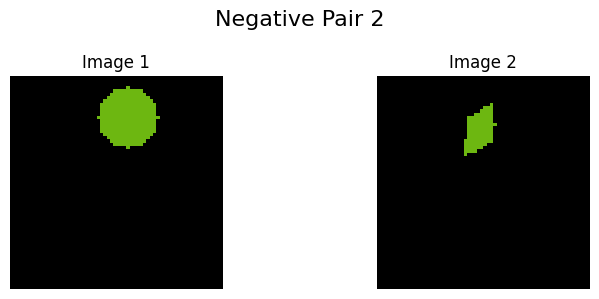

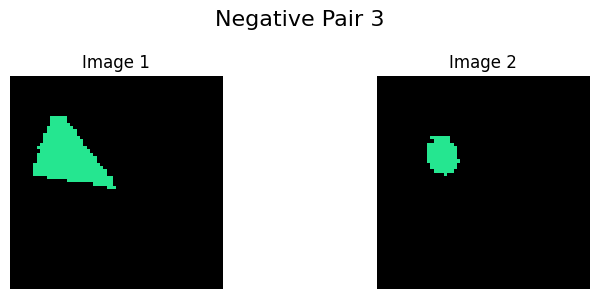

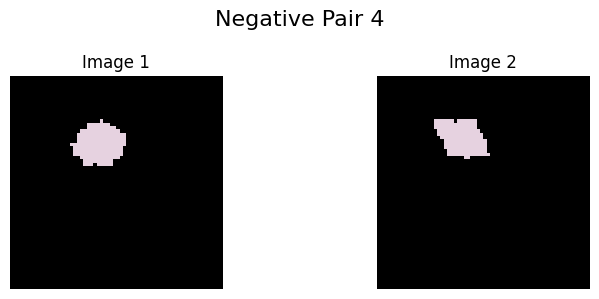

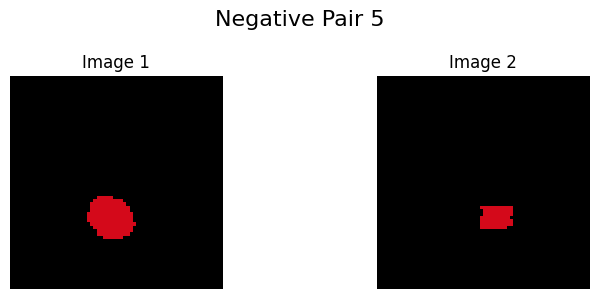

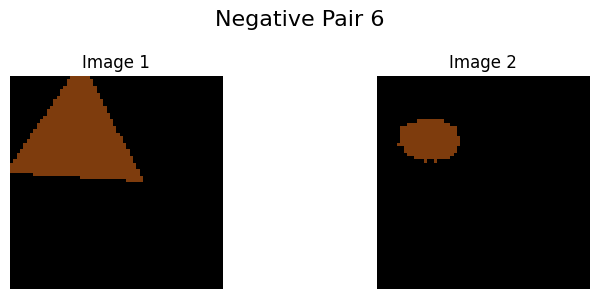

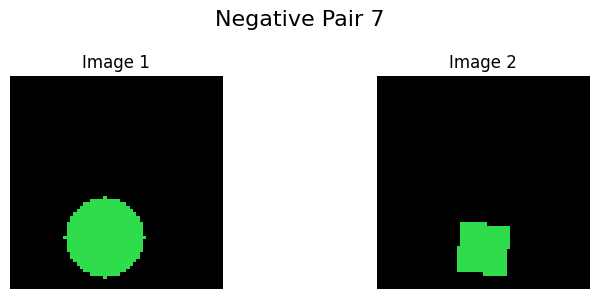

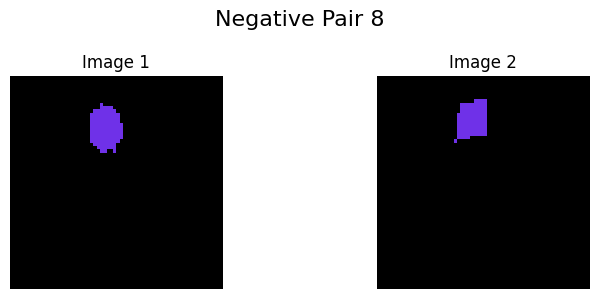

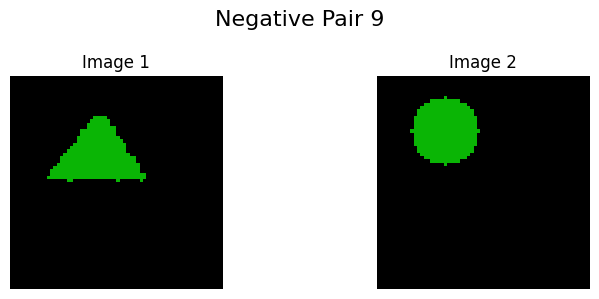

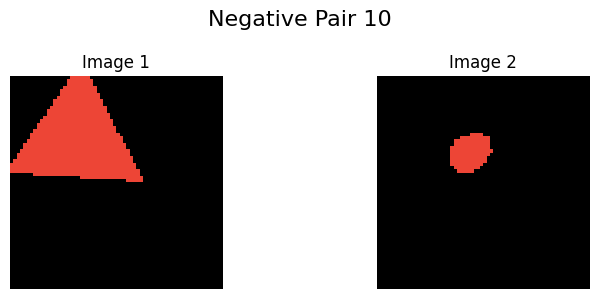

In [19]:
shape_dataset = ContrastiveDataset(target_property='shape')
shape_data_loader = DataLoader(shape_dataset, batch_size=32, shuffle=True)

shape_dataset.visualize_random_pairs(positive=True)
shape_dataset.visualize_random_pairs(positive=False)

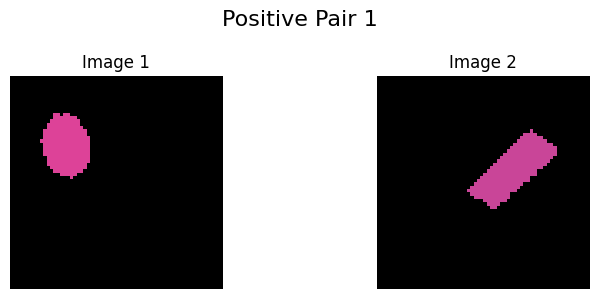

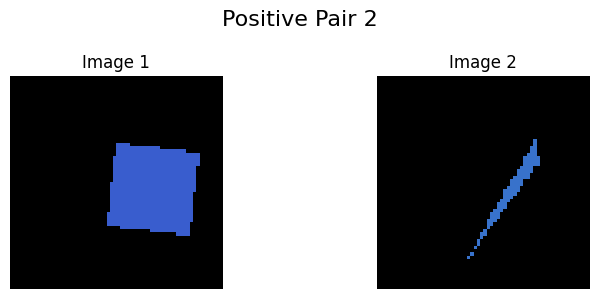

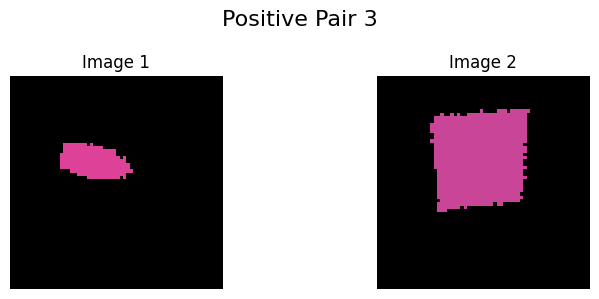

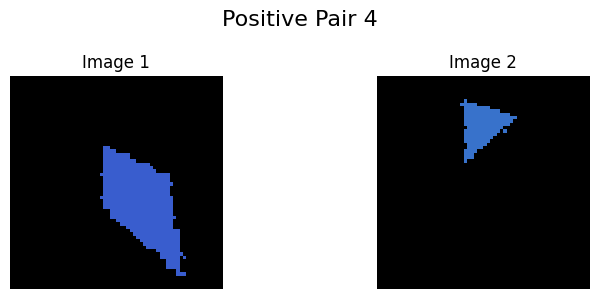

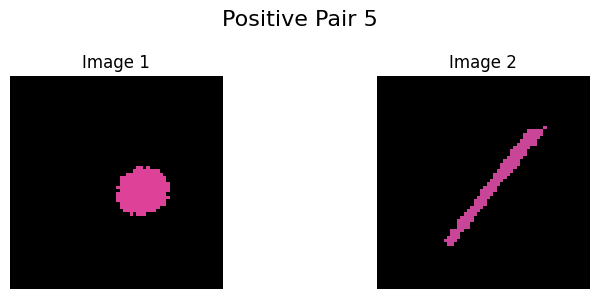

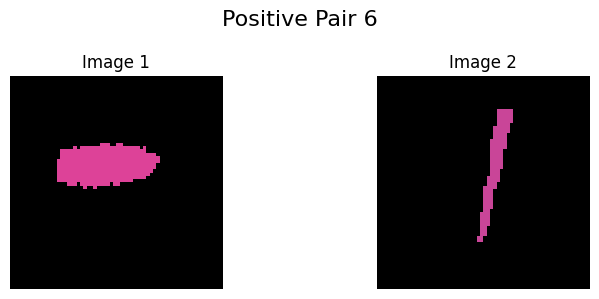

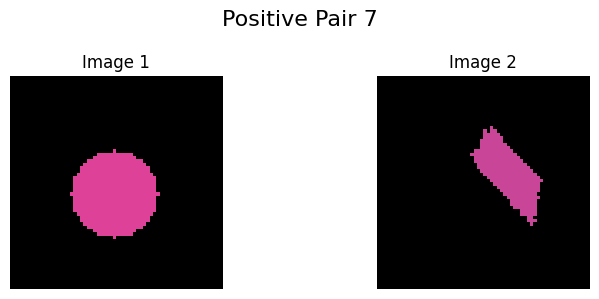

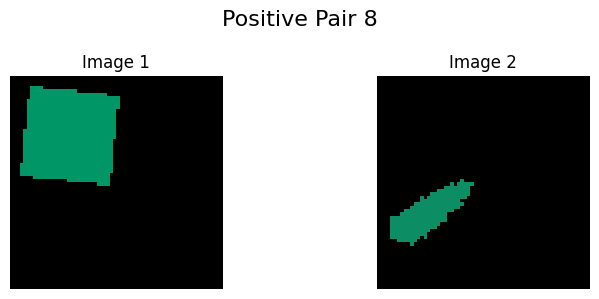

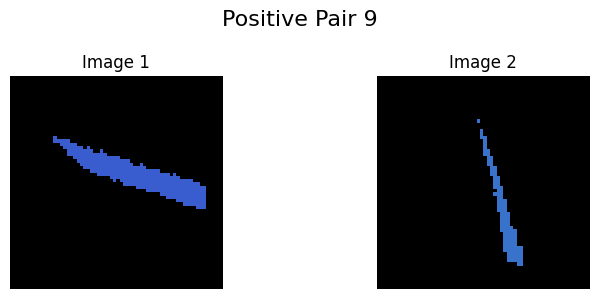

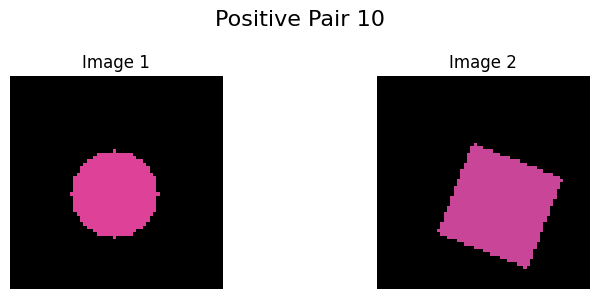

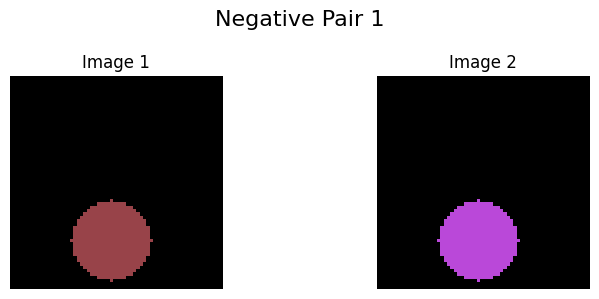

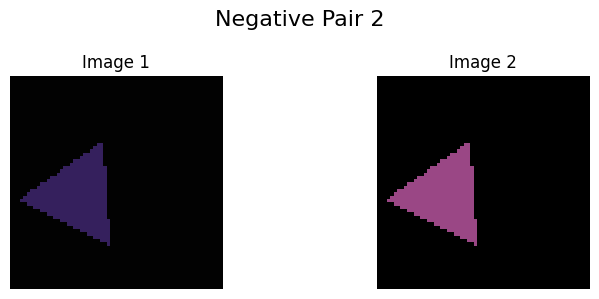

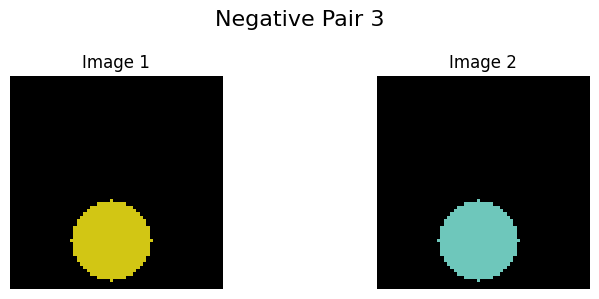

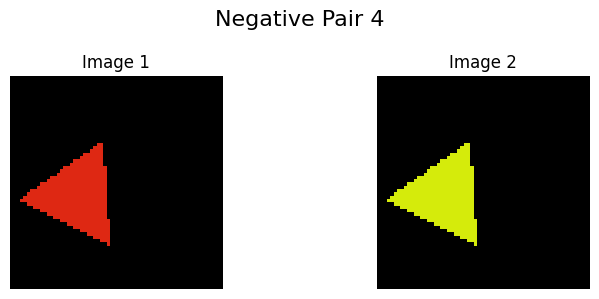

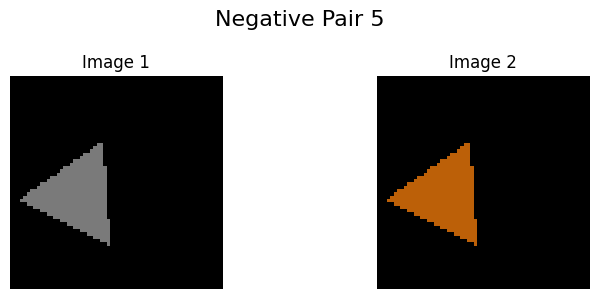

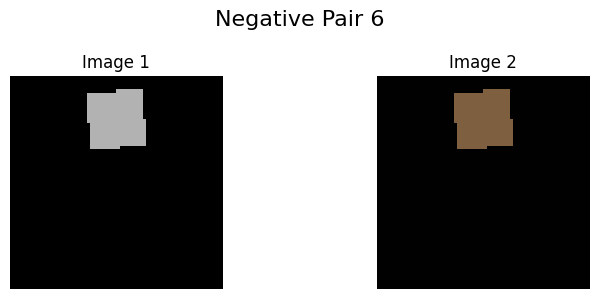

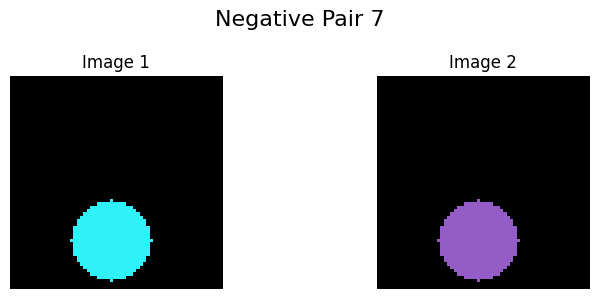

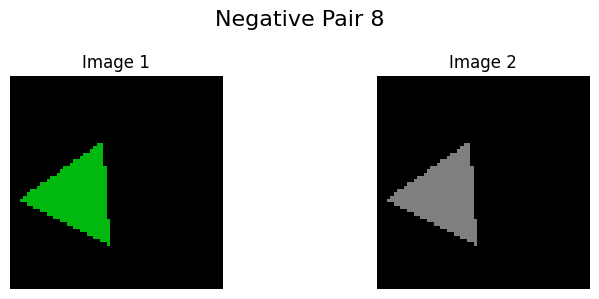

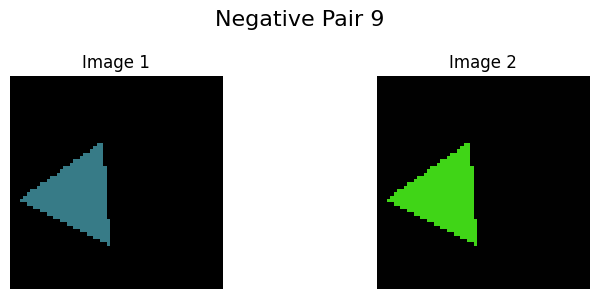

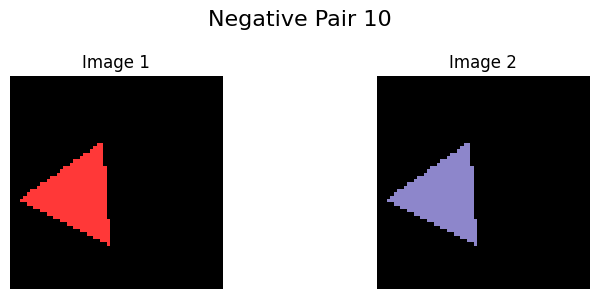

In [20]:
color_dataset = ContrastiveDataset(target_property='color')
color_data_loader = DataLoader(color_dataset, batch_size=32, shuffle=True)

color_dataset.visualize_random_pairs(positive=True)
color_dataset.visualize_random_pairs(positive=False)

In [26]:
location_encoder = train_contrastive(location_dataset, 'location', latent_dim=128)
location_features = get_features(location_dataset, location_encoder, firstk=1000).cpu()

location_knn_estim_2 = knn_estim(location_features.cpu(), k=2)
print("kNN estimated intrinsic dimension (k=2) for Location:", location_knn_estim_2)

location_corr_estim = correlation_dimension(location_features.cpu())
print("Correlation dimension for Location:", location_corr_estim)

Epoch 1 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 1 / 30, Loss: 0.1334


Epoch 2 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 2 / 30, Loss: 0.0410


Epoch 3 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 3 / 30, Loss: 0.0338


Epoch 4 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 4 / 30, Loss: 0.0298


Epoch 5 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 5 / 30, Loss: 0.0272


Epoch 6 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 6 / 30, Loss: 0.0255


Epoch 7 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 7 / 30, Loss: 0.0227


Epoch 8 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 8 / 30, Loss: 0.0233


Epoch 9 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 9 / 30, Loss: 0.0231


Epoch 10 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 10 / 30, Loss: 0.0200


Epoch 11 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 11 / 30, Loss: 0.0211


Epoch 12 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 12 / 30, Loss: 0.0226


Epoch 13 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 13 / 30, Loss: 0.0193


Epoch 14 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 14 / 30, Loss: 0.0179


Epoch 15 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 15 / 30, Loss: 0.0188


Epoch 16 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 16 / 30, Loss: 0.0185


Epoch 17 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 17 / 30, Loss: 0.0179


Epoch 18 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 18 / 30, Loss: 0.0150


Epoch 19 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 19 / 30, Loss: 0.0147


Epoch 20 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 20 / 30, Loss: 0.0151


Epoch 21 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 21 / 30, Loss: 0.0149


Epoch 22 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 22 / 30, Loss: 0.0126


Epoch 23 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 23 / 30, Loss: 0.0109


Epoch 24 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 24 / 30, Loss: 0.0100


Epoch 25 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 25 / 30, Loss: 0.0112


Epoch 26 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 26 / 30, Loss: 0.0103


Epoch 27 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 27 / 30, Loss: 0.0118


Epoch 28 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 28 / 30, Loss: 0.0095


Epoch 29 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 29 / 30, Loss: 0.0090


Epoch 30 / 30:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 30 / 30, Loss: 0.0084
kNN estimated intrinsic dimension (k=2) for Location: 2.0175429364026196
Correlation dimension for Location: 1.7783891478430809


In [27]:
shape_encoder = train_contrastive(shape_dataset, 'shape', latent_dim=128)
shape_features = get_features(shape_dataset, shape_encoder, firstk=1000).cpu()

shape_knn_estim_2 = knn_estim(shape_features.cpu(), k=2)
print("kNN estimated intrinsic dimension (k=2) for Shape:", shape_knn_estim_2)

shape_corr_estim = correlation_dimension(shape_features.cpu())
print("Correlation dimension for Shape:", shape_corr_estim)

Epoch 1 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 1 / 15, Loss: 0.2623


Epoch 2 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 2 / 15, Loss: 0.0701


Epoch 3 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 3 / 15, Loss: 0.0435


Epoch 4 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 4 / 15, Loss: 0.0451


Epoch 5 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 5 / 15, Loss: 0.0291


Epoch 6 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 6 / 15, Loss: 0.0203


Epoch 7 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 7 / 15, Loss: 0.0160


Epoch 8 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 8 / 15, Loss: 0.0148


Epoch 9 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 9 / 15, Loss: 0.0127


Epoch 10 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 10 / 15, Loss: 0.0146


Epoch 11 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 11 / 15, Loss: 0.0094


Epoch 12 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 12 / 15, Loss: 0.0090


Epoch 13 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 13 / 15, Loss: 0.0107


Epoch 14 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 14 / 15, Loss: 0.0088


Epoch 15 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 15 / 15, Loss: 0.0078
kNN estimated intrinsic dimension (k=2) for Shape: 4.31798622067235
Correlation dimension for Shape: 0.6630834443182118


In [28]:
color_encoder = train_contrastive(color_dataset, 'color', latent_dim=128)
color_features = get_features(color_dataset, color_encoder, firstk=1000).cpu()

color_knn_estim_2 = knn_estim(color_features.cpu(), k=2)
print("kNN estimated intrinsic dimension (k=2) for Color:", color_knn_estim_2)

color_corr_estim = correlation_dimension(color_features.cpu())
print("Correlation dimension for Color:", color_corr_estim)

Epoch 1 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 1 / 15, Loss: 0.2291


Epoch 2 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 2 / 15, Loss: 0.0728


Epoch 3 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 3 / 15, Loss: 0.0404


Epoch 4 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 4 / 15, Loss: 0.0266


Epoch 5 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 5 / 15, Loss: 0.0181


Epoch 6 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 6 / 15, Loss: 0.0198


Epoch 7 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 7 / 15, Loss: 0.0141


Epoch 8 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 8 / 15, Loss: 0.0132


Epoch 9 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 9 / 15, Loss: 0.0114


Epoch 10 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 10 / 15, Loss: 0.0096


Epoch 11 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 11 / 15, Loss: 0.0082


Epoch 12 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 12 / 15, Loss: 0.0086


Epoch 13 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 13 / 15, Loss: 0.0079


Epoch 14 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 14 / 15, Loss: 0.0064


Epoch 15 / 15:   0%|          | 0/40 [00:00<?, ?it/s]

[Contrastive] Epoch 15 / 15, Loss: 0.0070
kNN estimated intrinsic dimension (k=2) for Color: 4.409889505543026
Correlation dimension for Color: 0.5992233825753005
